# Personalized Movie Recommendation Map

In part 1 of my data exploration, I showed that most users have 2 or 3 favorite genres. Now I'd like to look at a different aspect of the data - how does the number of movies rated in each genre correspond to a user's average rating of that genre? 

I would expect that users tend to rate more movies from genres that they like. For example, if one person rated 18 comedies and 2 horror movies, I would expect that he watched more comedies than horror movies, because he tends to like comedies more than horror movies. 

It is a bit tricky to compare average ratings between users, because one user may tend to give higher ratings than another use. I'll handle this by standardizing each user's ratings:

$$ rating_{standardized} = \frac{rating-mean(rating)}{\sigma}$$

I will also have to standardize the number of ratings given to each genre, because some users rate many more movies than others. The easiest way to do this will be to look at what percent of each user's ratings were given to a particular genre. 

In [1]:
import pandas as pd
import matplotlib
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns

In [2]:
ratings = pd.read_csv('../ml-20m/ratings.csv') #userId,movieId,rating,timestamp
movies = pd.read_csv('../ml-20m/movies.csv') #movieId,title,genres

In [3]:
def parse_genres(s):
    return set(s.split('|'))

In [4]:
movies['p_genres'] = movies['genres'].apply(parse_genres)

In [5]:
# Create a set of all the genres for the entire dataset
genres = set().union(*list(movies['p_genres']))

In [6]:
len(ratings.userId.unique())

138493

The most efficient way to do this will be to create two matrices, rating_count, and rating_by_genre. Both matrices will be of the size nxg (n= number of users, and g= number of genres), and element (i,j) will represent the number of ratings, or the average rating user i gave to movies from genre j. 

This is a very large dataset, with 138493 users. I will only need to use a subset of the data to determine the general trend of the dataset, so I will randomly choose a set of users to look at for this plot. 

In [7]:
num_genres = len(genres)
genre_index = dict(zip(genres,range(num_genres))) # Assign integers to genres so each matrix row
                                                  # will correspond to individual genres
num_users = len(ratings.userId.unique())
num_movies = len(ratings.movieId.unique())
max_user_ratings = max(ratings.userId.value_counts())

num_users_sample = 1000

In [8]:
userID_sample = np.random.randint(1,num_users,num_users_sample)
user_index = dict(zip(userID_sample,range(num_users_sample)))

ratings_sample = ratings.loc[ratings.userId.isin(userID_sample)]

In [9]:
rating_by_genre = np.empty([num_users_sample,num_genres])
rating_count = np.empty([num_users_sample,num_genres])

In [10]:
def parse_user_ratings_by_genre(Id):
    
    rating_dict = {g:[] for g in genres}
    all_ratings = []
    
    for ratings_index in ratings_sample.loc[ratings_sample['userId']==Id].index:
        
        all_ratings.append(ratings_sample.loc[ratings_index,'rating'])
        
        m = ratings['movieId'].loc[ratings_index]
        
        if m < 27278:
            g_list = movies.loc[m-1].p_genres
            
            for g in g_list:
                rating_dict[g].append(ratings_sample.loc[ratings_index].rating)
        
    rating_mean = np.mean(all_ratings)
    rating_std = np.std(all_ratings)
    num_ratings = len(all_ratings)
    
    r = np.full((num_genres),np.nan)
    c = np.full((num_genres),np.nan)
    
    for g in genres:
        #r[genre_index[g]]=np.mean(np.divide(np.subtract(rating_dict[g],np.mean(all_ratings)),np.std(all_ratings)))
        r[genre_index[g]]=np.mean(rating_dict[g])
        c[genre_index[g]]= len(rating_dict[g])/num_ratings
        #c[genre_index[g]]= len(rating_dict[g])
    
    return r,c

In [11]:
from time import time
t0 = time()
for usr,ind in user_index.items():
    rating_by_genre[ind,:],rating_count[ind,:]=parse_user_ratings_by_genre(usr)
print("time: {}".format(round(time()-t0, 3)))

/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


time: 123.101


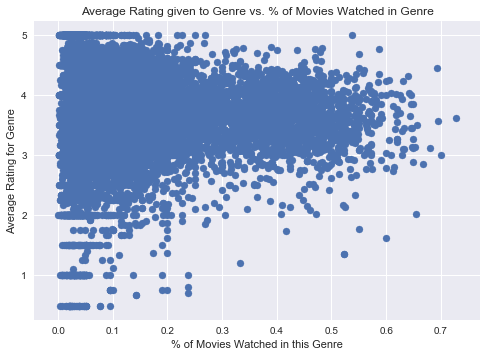

In [12]:
plt.scatter(rating_count.reshape(num_users_sample*num_genres),
            rating_by_genre.reshape(num_users_sample*num_genres))

plt.xlabel('% of Movies Watched in this Genre')
plt.ylabel('Average Rating for Genre')
plt.title('Average Rating given to Genre vs. % of Movies Watched in Genre')

This shows what I expected. Most of the lower ratings were given in genres that people watched more rarely, and users tend to give higher ratings to genres they watch more often. 